Execution for house price estimation

In [1]:
# Import relevant files and libraries
import DataProcessor
import sys
import LRegression
import NLRegression
import performance_metrics
import Kmeans
import UserInterface

Define the parameters



In [2]:
# Allocate 80% of data to training
train_size = 0.8

# Identify features to be used
columnsToKeep = ['BHK','Rent','Size','Bathroom']
#columnsToKeep = ['Price', 'Bedroom', 'Bathroom']
#columnsToKeep = ['Price', 'Type', 'Landsize', 'BuildingArea']

# Path to dataset.
filepath = '../dataset/House_Rent_Dataset.csv'

# Identify prediction (ground truth)
prediction_column = 'Rent'

Process raw data

Data Processor object created


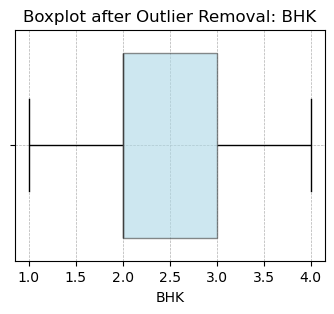

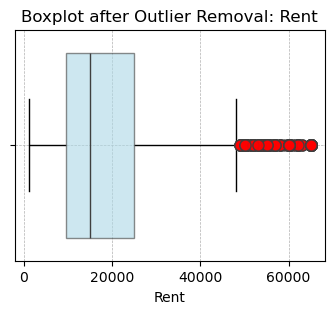

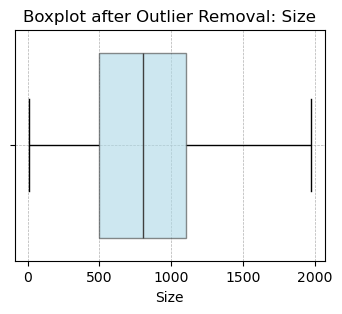

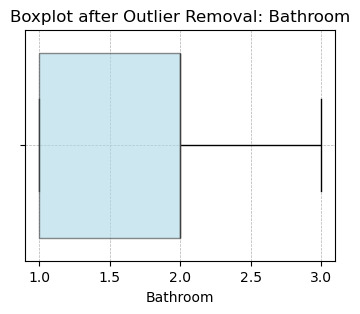

Number of rows removed: 668
Number of rows remaining: 4078
training size 3262
test size 816


In [3]:
# Create a DataProcessor object and load the data
dp_obj = DataProcessor.DataProcessor()
dp_obj.LoadData(filepath)

# Remove incomplete points, remove unused features and shuffle the data
dp_obj.keepSelectedColumns(columnsToKeep)

dp_obj.remove_outliers(columnsToKeep, plot=True)

# dp_obj.encodeCategoricalData(['Type'])
dp_obj.shuffleData()

# Split the data into training and testing
train_X, train_Y, test_X, test_Y = dp_obj.splitData(train_size, prediction_column)


K-Means Clustering

In [ ]:
# Ashton
k = 10
prefs = ['Type','Bedroom','Bathroom','Car','Landsize','BuildingArea','Latitude','Longitude']

all_points = []
all_centroids = []

for pref in prefs:
    kmeans = Kmeans.Kmeans(train_X, train_Y, k, pref)

    train_X, points, centroids = kmeans.cluster()

    all_points.append(points)
    all_centroids.append(centroids)

    kmeans.plotKmean(train_X, points, centroids, pref)

Linear Regression

In [ ]:
# TEMPORARY
k = 5
pref = 'Size'
km = kmeans.Kmeans(train_X_clean,train_Y,k,pref)

train_X, points, centroids = km.cluster()
print(train_X['Assignment'].shape)

In [ ]:
lr = LRegression.LRegression()
for i in range(k):
    features = train_X[train_X['Assignment'] == i]
    features = features.drop('Assignment',axis=1)
    targets = train_Y[train_X['Assignment'] == i]
    y_pred = lr.LinearRegression(features=features,target=targets)
    print(y_pred)

In [ ]:
lr = LRegression.LRegression()
assignments = train_X['Assignment']
# features = train_X.drop('Assignment',axis=1)
features = train_X
models = lr.LinearReg(assignments,features,train_Y)

In [ ]:
# Train
lr = LRegression.LRegression()
y_pred = []
# for i in range(k):
#     y_pred.append(lr.LinReg(features=train_X,target=train_Y,assignment=i))
y_pred = lr.LinReg(features=train_X,target=train_Y,assignment=train_X['Assignment'])

In [ ]:
# Test


Non-Linear Regression (Gaussian Processing)

In [4]:
# Train

# options: 'Type','Bedroom','Bathroom','Car','Size','Latitude','Longitude'
featuresToTrain = ['BHK','Size','Bathroom']


nlr = NLRegression.NLRegression(train_X, train_Y, test_X, test_Y, featuresToTrain)
nlr.train()

/opt/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


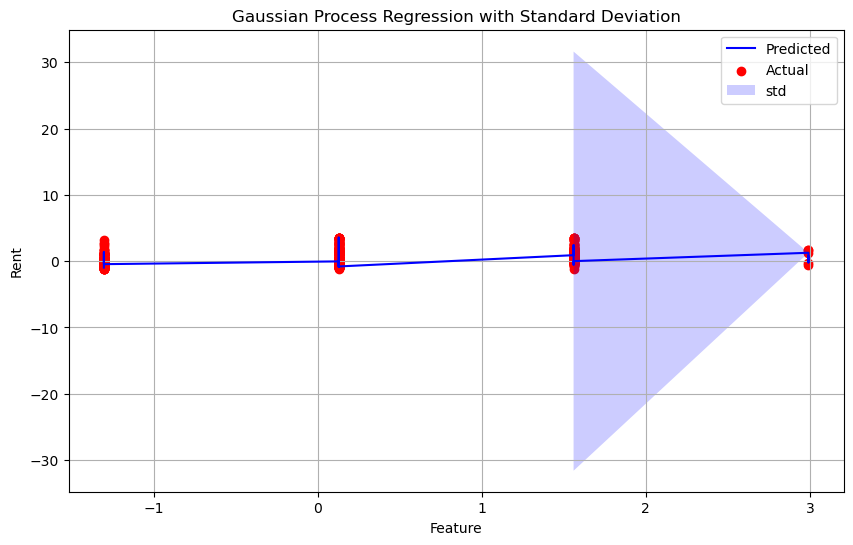

In [5]:
# plotting predictions vs expected

nlr.plot()

In [ ]:
# Quick Test
nlr.evaluate()

In [16]:
# test on 2 rows
sample = nlr.scaleData(test_X.iloc[4:6])

pred, std = nlr.predict(sample)
print(pred)
print(std)

[0. 0.]
[31.61571512 31.61571512]


In [ ]:
# slow but more accurate test
nlr.cross_validate()

Evaluation Metrics

In [ ]:
from performance_metrics import ElbowMethod
from DataProcessor import DataProcessor
import pandas as pd
from sklearn.impute import SimpleImputer

# Identify features to be used (excluding 'Type')
columnsToKeep = ['Price', 'Bedroom', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Latitude', 'Longitude']

# Path to dataset
filepath = '../dataset/Melbourne_housing_FULL.csv'

# Step 1: Load and preprocess the data
data_processor = DataProcessor()
data = data_processor.LoadData(filepath)

# Drop columns that are not relevant or cannot be converted to numeric
data = data_processor.keepSelectedColumns(columnsToKeep)

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Step 2: Use the ElbowMethod class with the preprocessed data
elbow_method = ElbowMethod(data)  # Initialize ElbowMethod
elbow_method.evaluate(max_clusters=10)
elbow_method.plot()
optimal_clusters = elbow_method.optimal_number_of_clusters()
print("Optimal number of clusters:", optimal_clusters)


In [ ]:
from performance_metrics import calculate_silhouette_score
# Assuming kmeans.cluster() returns x_new, points, centroids
x_new, points, centroids = kmeans.cluster()
assignment = x_new['Assignment' + pref].values  # Extract the cluster assignments

silhouette_avg = calculate_silhouette_score(points, assignment)
print("Silhouette Score:", silhouette_avg)

User input for preference

In [ ]:
# Calculate mean values if no user preference is provided
meanLand = dp_obj.getAverage('Landsize')
meanBuilding = dp_obj.getAverage('BuildingArea')

# Input user preferences
user_pref = UserInterface.UserInterface()
type, bedrooms, bathrooms, car, size, latitude, longitude = user_pref.Inputs(meanLand, meanBuilding)
print(type,bedrooms,bathrooms,car,size,latitude,longitude)

Final prediction

In [ ]:
# Return predicted value from best performing model
targets = [type,bedrooms,bathrooms,car,size,latitude,longitude]
pred = lr.predict(features=targets)